In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats

data = pd.read_csv("data/Data.csv")
data.head()

ID District      Block  CultLand  CropCultLand  \
0  ID_GTFAC7PEVWQ9  Nalanda  Noorsarai        45            40   
1  ID_TK40ARLSPOKS  Nalanda     Rajgir        26            26   
2  ID_1FJY2CRIMLZZ     Gaya      Gurua        10            10   
3  ID_I3IPXS4DB7NE     Gaya      Gurua        15            15   
4  ID_4T8YQWXWHB4A  Nalanda  Noorsarai        60            60   

                               LandPreparationMethod CropTillageDate  \
0               TractorPlough FourWheelTracRotavator      2022-07-20   
1  WetTillagePuddling TractorPlough FourWheelTrac...      2022-07-18   
2               TractorPlough FourWheelTracRotavator      2022-06-30   
3               TractorPlough FourWheelTracRotavator      2022-06-16   
4                   TractorPlough WetTillagePuddling      2022-07-19   

   CropTillageDepth         CropEstMethod RcNursEstDate  ... Harv_method  \
0                 5  Manual_PuddledRandom    2022-06-27  ...     machine   
1                 5  Manual_PuddledRandom    2022-06-20  ...        hand   
2                 6  Manual_PuddledRandom    2022-06-20  ...        hand   
3                 6  Manual_PuddledRandom    2022-06-17  ...        hand   
4                 4  Manual_PuddledRandom    2022-06-21  ...     machine   

    Harv_date Harv_hand_rent Threshing_date  Threshing_method Residue_length  \
0  2022-11-16            NaN     2022-11-16           machine             30   
1  2022-11-25            3.0     2022-12-24           machine             24   
2  2022-12-12          480.0     2023-01-11           machine             30   
3  2022-12-02          240.0     2022-12-29              hand             26   
4  2022-11-30            NaN     2022-12-02           machine             24   

  Residue_perc     Stubble_use      Acre Yield  
0           40  plowed_in_soil  0.312500   600  
1           10  plowed_in_soil  0.312500   600  
2           10  plowed_in_soil  0.148148   225  
3           10  plowed_in_soil  0.222222   468  
4           40  plowed_in_soil  0.468750   550  

[5 rows x 44 columns]

In [2]:
y = data['Yield']
X = data.drop(['Yield', 'ID'], axis=1)

## Начнем с базового препроцессинга

In [3]:
for feature in X.select_dtypes(include=[np.number]).columns:
        median_value = X[feature].median() 
        X[feature] = X[feature].fillna(median_value)

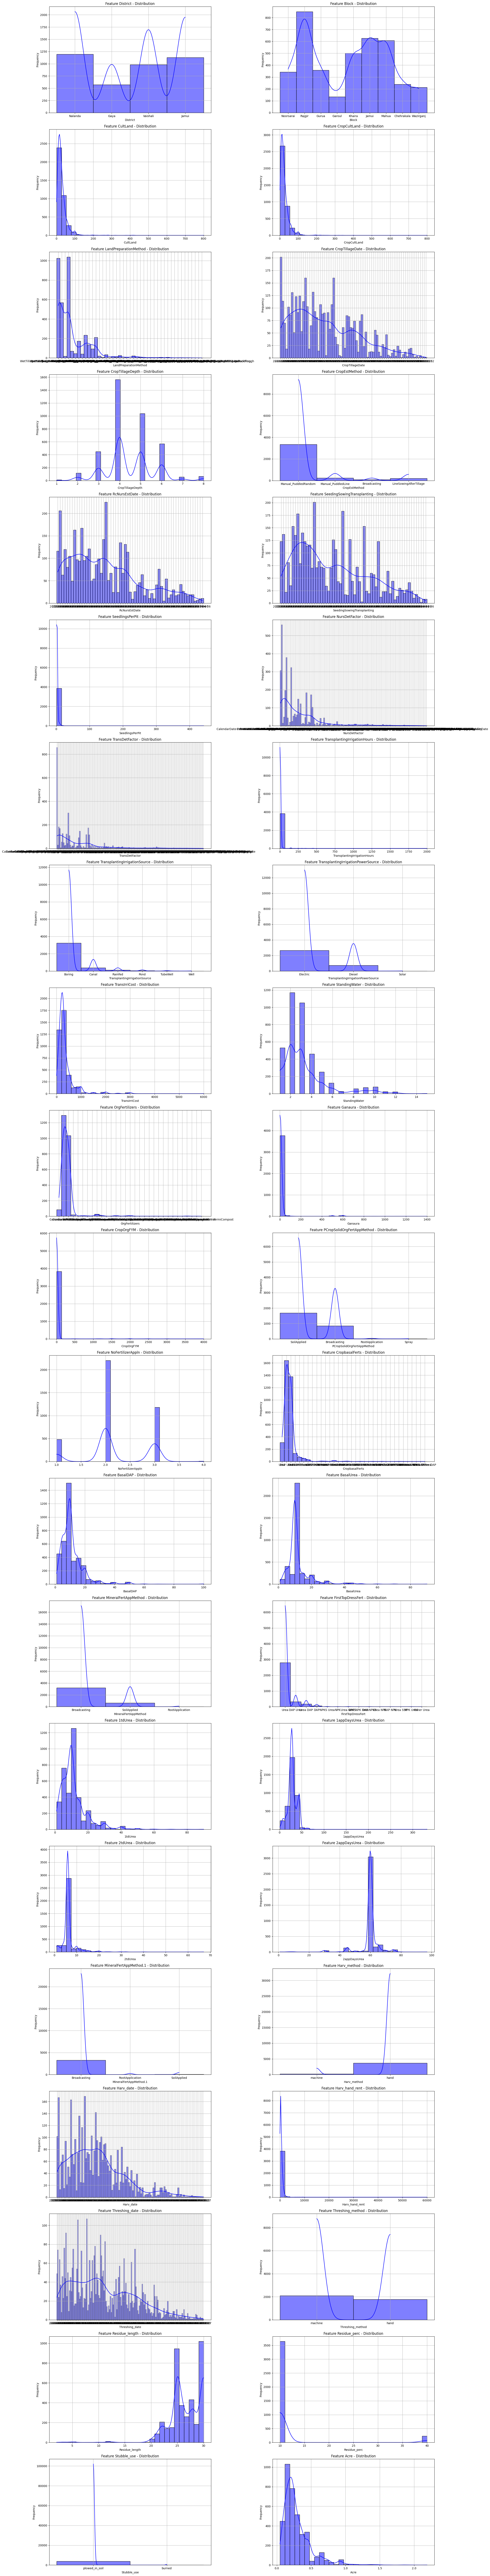

Plotting correlation matrix...


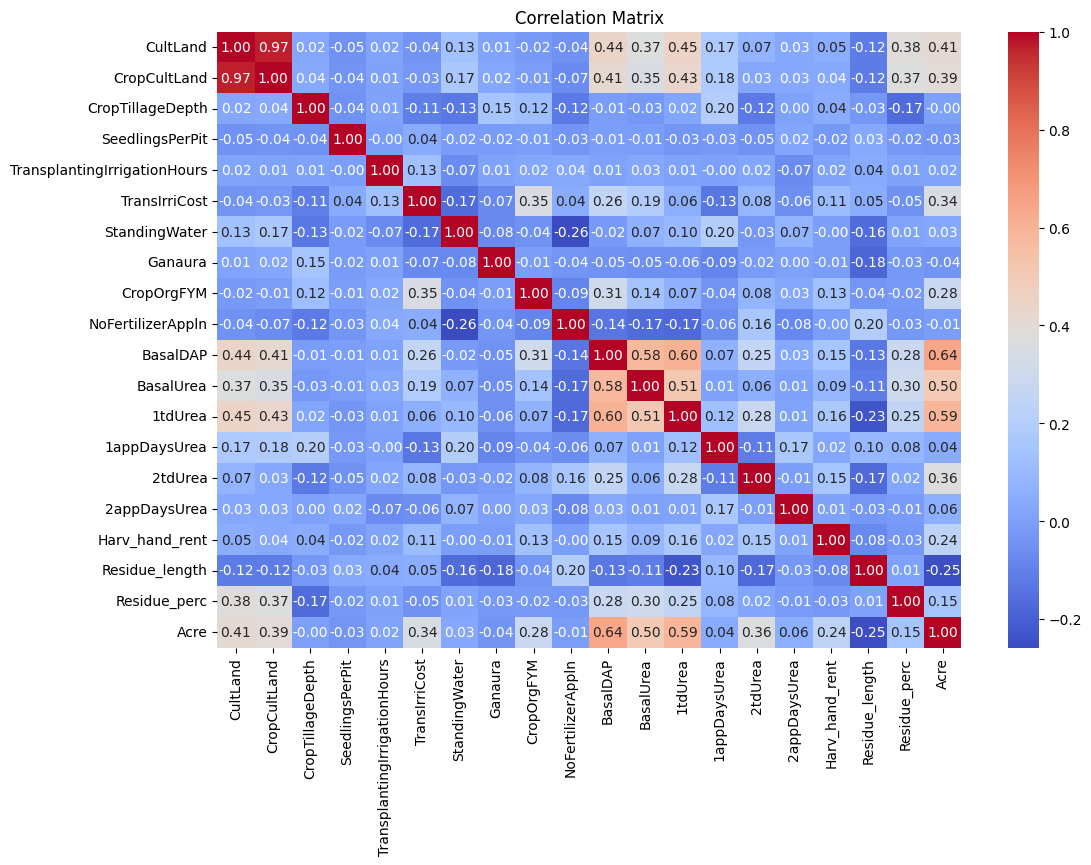

In [4]:
def analyze_distributions_and_correlation(data, title_prefix="Feature"):
    num_columns = len(data.columns)
    rows = (num_columns // 2) + (num_columns % 2 > 0)
    
    fig, axes = plt.subplots(rows, 2, figsize=(24, 6 * rows))
    axes = axes.flatten()  

    for i, column in enumerate(data.columns):
        sns.histplot(data[column], kde=True, bins=30, color="blue", ax=axes[i])
        axes[i].set_title(f"{title_prefix} {column} - Distribution")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel("Frequency")
        axes[i].grid()
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

    print("Plotting correlation matrix...")
    correlation_matrix = data[data.select_dtypes(include=[np.number]).columns].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

    return correlation_matrix

correlation_matrix = analyze_distributions_and_correlation(X)


In [5]:
train_data, test_data, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
train_data, val_data, y_train, y_val = train_test_split(train_data, y_train, test_size=2./9, random_state=42) 

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
train_data, val_data, y_train, y_val = train_test_split(train_data, y_train, test_size=2./9, random_state=42) 

train_reduced = train_data.select_dtypes(include=['number'])
val_reduced = val_data.select_dtypes(include=['number'])
test_reduced = test_data.select_dtypes(include=['number'])

train = train_data
val = val_data
test = test_data

### Модель

In [7]:
import numpy as np

class LinearRegressionElasticNet:
    def __init__(self, epsilon=1e-6, max_steps=10000, w0=None, b0=None, alpha=1e-5, l1_ratio=0.5, lam=1e-2):
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.w0 = w0
        self.alpha = alpha  
        self.l1_ratio = l1_ratio  
        self.lam = lam  
        self.w = None
        self.b0 = b0
        self.b = None
        
    def fit(self, X, y):
        X = self._scale_features(X)
        y = self._scale_target(y)

        l, d = X.shape

        if self.w0 is None:
            self.w0 = np.zeros(d)
        self.w = self.w0.copy()

        if self.b0 is None:
            self.b0 = 0.0
        self.b = self.b0

        for step in range(self.max_steps):
            y_pred = np.dot(X, self.w) + self.b
            residuals = y_pred - y

            grad_loss_w = (2 / l) * np.dot(X.T, residuals)
            grad_reg_w = self.lam * (self.l1_ratio * np.sign(self.w) + (1 - self.l1_ratio) * self.w)
            gradient_w = grad_loss_w + grad_reg_w
            gradient_w = np.clip(gradient_w, -1e5, 1e5)
            if np.isnan(gradient_w).any():
                raise ValueError("NaN detected in gradients. Try reducing the learning rate.")

            gradient_b = (2 / l) * np.sum(residuals)
            w_new = self.w - self.alpha * gradient_w
            b_new = self.b - self.alpha * gradient_b

            if np.linalg.norm(w_new - self.w) < self.epsilon:
                self.w = w_new
                self.b = b_new
                break
                
            self.w = w_new
            self.b = b_new

        self.X_mean = self.X_mean_
        self.X_std = self.X_std_
        self.y_mean = self.y_mean_
        self.y_std = self.y_std_

        return self
    
    def predict(self, X):
        if self.w is None or self.b is None:
            raise Exception('Model has not been trained yet')
        
        X_scaled = (X - self.X_mean) / self.X_std
        y_pred_scaled = np.dot(X_scaled, self.w) + self.b
        return y_pred_scaled * self.y_std + self.y_mean

    def get_b(self):
        return self.b * self.y_std + self.y_mean - np.dot(self.X_mean / self.X_std, self.w * self.y_std)

    def _scale_features(self, X):
        self.X_mean_ = np.mean(X, axis=0)
        self.X_std_ = np.std(X, axis=0)
        self.X_std_[self.X_std_ == 0] = 1.0
        return (X - self.X_mean_) / self.X_std_

    def _scale_target(self, y):
        self.y_mean_ = np.mean(y)
        self.y_std_ = np.std(y)
        if self.y_std_ == 0:
            self.y_std_ = 1.0
        return (y - self.y_mean_) / self.y_std_


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    report = {
        'Metric': ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE'],
        'Value': [
            mean_absolute_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred),
            mean_squared_error(y_true, y_pred, squared=False),
            r2_score(y_true, y_pred),
            np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        ]
    }
    return pd.DataFrame(report)

In [8]:
custom_model = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=1e-3,      
    l1_ratio=0.005,  
    lam=1e-2        
)

custom_model.fit(train_reduced, y_train)


In [9]:
y_pred = custom_model.predict(test_reduced)
report_df = regression_report(y_test, y_pred)
report_df

c:\Users\edimv\Desktop\MOMO\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metric          Value
0    MAE     181.224639
1    MSE  649246.786621
2   RMSE     805.758516
3     R²       0.283927
4   MAPE     147.520880

In [10]:
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    lam = trial.suggest_float('lam', 1e-3, 1e-1)

    model = LinearRegressionElasticNet(
        max_steps=10000,
        alpha=alpha,
        l1_ratio=l1_ratio,
        lam=lam
    )

    model.fit(train_reduced, y_train)
    y_pred = model.predict(val_reduced)

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print("Best trial:")
print(study.best_trial.params)


c:\Users\edimv\Desktop\MOMO\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-06 13:36:49,503] A new study created in memory with name: no-name-48c118e9-6272-4770-8d30-db72c9894a13
[I 2024-12-06 13:36:52,517] Trial 0 finished with value: 403.21714203888905 and parameters: {'alpha': 0.01719179101952932, 'l1_ratio': 0.4645214471339373, 'lam': 0.09321365259181337}. Best is trial 0 with value: 403.21714203888905.
[I 2024-12-06 13:36:55,548] Trial 1 finished with value: 403.9094274346179 and parameters: {'alpha': 0.025590652550711888, 'l1_ratio': 0.7993664518436961, 'lam': 0.067232829162742}. Best is trial 0 with value: 403.21714203888905.
[I 2024-12-06 13:36:58,557] Trial 2 finished with value: 401.0638322869934 and parameters: {'alpha': 0.025833345158265256, 'l1_ratio': 0.7722009278483772, 'lam': 0.0105

Best trial:
{'alpha': 0.014334055015451753, 'l1_ratio': 0.08958049720163386, 'lam': 0.0570633237103392}


In [11]:
best_params = study.best_trial.params

custom_model = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=best_params['alpha'],
    l1_ratio=best_params['l1_ratio'],
    lam=best_params['lam']
)

custom_model.fit(train_reduced, y_train)
y_pred = custom_model.predict(test_reduced)

report_df = regression_report(y_test, y_pred)
report_df

c:\Users\edimv\Desktop\MOMO\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metric          Value
0    MAE     182.104353
1    MSE  653910.601958
2   RMSE     808.647390
3     R²       0.278784
4   MAPE     157.070054

## Поработаем с признаками

In [12]:
train = train_reduced
val = val_reduced
test = test_reduced

Уберем выбросы

In [13]:
all_data = pd.concat([train, val, test], axis=0)  

all_data.columns = all_data.columns.astype(str)
indices_to_keep = all_data.index
for feature in all_data.select_dtypes(include=[np.number]).columns:
    Q1 = all_data[feature].quantile(0.01)
    Q3 = all_data[feature].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    valid_indices = all_data[(all_data[feature] >= lower_bound) & (all_data[feature] <= upper_bound)].index
    indices_to_keep = indices_to_keep.intersection(valid_indices)

all_data = all_data.loc[indices_to_keep]
y = y.loc[indices_to_keep]

all_data = all_data.reset_index(drop=True)
y = y.reset_index(drop=True)

Как выглядит таргет

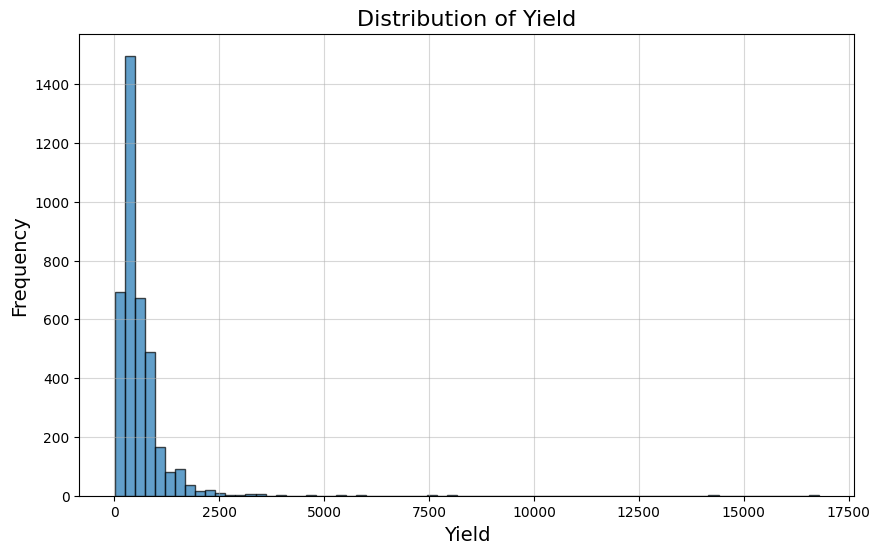

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(y, bins=70, alpha=0.7, edgecolor='black')
plt.title('Distribution of Yield', fontsize=16)
plt.xlabel('Yield', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.5)
plt.show()

Сильно скошенный, нужно будет поправить например преобразованием Бокса-Кокса

Нормализация

In [15]:

scaler_type = 'standard'
if scaler_type == 'standard':
    scaler = StandardScaler()
elif scaler_type == 'minmax':
    scaler = MinMaxScaler()
else:
    raise ValueError("Scaler type must be 'standard' or 'minmax'")
all_data_scaled = pd.DataFrame(scaler.fit_transform(all_data), columns=all_data.columns)


Описательная статистика

In [16]:
def descriptive_statistics(data):
    stats = pd.DataFrame(index=data.columns)

    stats['Mean'] = data.mean()
    stats['Median'] = data.median()
    stats['Std Dev'] = data.std()
    stats['Range'] = data.max() - data.min()
    stats['25th Percentile'] = data.quantile(0.25)
    stats['50th Percentile (Median)'] = data.quantile(0.50)
    stats['75th Percentile'] = data.quantile(0.75)
    stats['Skewness'] = data.skew()
    stats['Kurtosis'] = data.kurt()

    return stats

descriptive_stats = descriptive_statistics(all_data_scaled)

descriptive_stats

Mean    Median   Std Dev      Range  \
CultLand                      3.923586e-17 -0.322766  1.000132  11.520789   
CropCultLand                 -3.736749e-18 -0.184940  1.000132  10.732701   
CropTillageDepth             -3.222946e-16 -0.421135  1.000132   6.190519   
SeedlingsPerPit              -2.428887e-17 -0.275207  1.000132  10.531303   
TransplantingIrrigationHours -2.428887e-17 -0.122129  1.000132  16.862106   
TransIrriCost                 3.923586e-17 -0.258426  1.000132   9.642624   
StandingWater                -7.893881e-17 -0.114990  1.000132   6.513056   
Ganaura                       2.335468e-18 -0.133711  1.000132  16.302852   
CropOrgFYM                   -1.121025e-17 -0.171699  1.000132  23.211509   
NoFertilizerAppln             7.473497e-18 -0.300561  1.000132   4.742874   
BasalDAP                     -6.352473e-17 -0.140835  1.000132   8.453767   
BasalUrea                     6.072216e-17 -0.242641  1.000132  12.532590   
1tdUrea                       4.297261e-17 -0.152442  1.000132  11.219120   
1appDaysUrea                 -5.231448e-17 -0.096412  1.000132   7.291704   
2tdUrea                       1.186418e-16 -0.126457  1.000132  12.655727   
2appDaysUrea                 -1.494699e-16  0.058922  1.000132  15.267259   
Harv_hand_rent                5.231448e-17 -0.198315  1.000132  13.376159   
Residue_length                1.270495e-16 -0.188055  1.000132   8.246915   
Residue_perc                 -1.868374e-18 -0.248986  1.000132   4.265281   
Acre                          1.149050e-16 -0.303826  1.000132   9.635565   

                              25th Percentile  50th Percentile (Median)  \
CultLand                            -0.653112                 -0.322766   
CropCultLand                        -0.634007                 -0.184940   
CropTillageDepth                    -0.421135                 -0.421135   
SeedlingsPerPit                     -0.275207                 -0.275207   
TransplantingIrrigationHours        -0.218760                 -0.122129   
TransIrriCost                       -0.469424                 -0.258426   
StandingWater                       -0.580208                 -0.114990   
Ganaura                             -0.133711                 -0.133711   
CropOrgFYM                          -0.171699                 -0.171699   
NoFertilizerAppln                   -0.300561                 -0.300561   
BasalDAP                            -0.713972                 -0.140835   
BasalUrea                           -0.242641                 -0.242641   
1tdUrea                             -0.656673                 -0.152442   
1appDaysUrea                        -0.392022                 -0.096412   
2tdUrea                             -0.126457                 -0.126457   
2appDaysUrea                         0.058922                  0.058922   
Harv_hand_rent                      -0.743302                 -0.198315   
Residue_length                      -0.517931                 -0.188055   
Residue_perc                        -0.248986                 -0.248986   
Acre                                -0.667748                 -0.303826   

                              75th Percentile   Skewness    Kurtosis  
CultLand                             0.296631   3.306036   20.434142  
CropCultLand                         0.264126   2.954499   15.393096  
CropTillageDepth                     0.463225   0.361986    0.796409  
SeedlingsPerPit                      0.226284   3.973415   22.560610  
TransplantingIrrigationHours        -0.073814  11.542054  150.996918  
TransIrriCost                        0.193713   4.223583   25.291453  
StandingWater                        0.350229   1.915009    4.116827  
Ganaura                             -0.133711   8.242756   72.356300  
CropOrgFYM                          -0.171699  11.318676  195.253298  
NoFertilizerAppln                    1.280397  -0.134017   -0.525033  
BasalDAP                             0.289017   2.293992    8.5

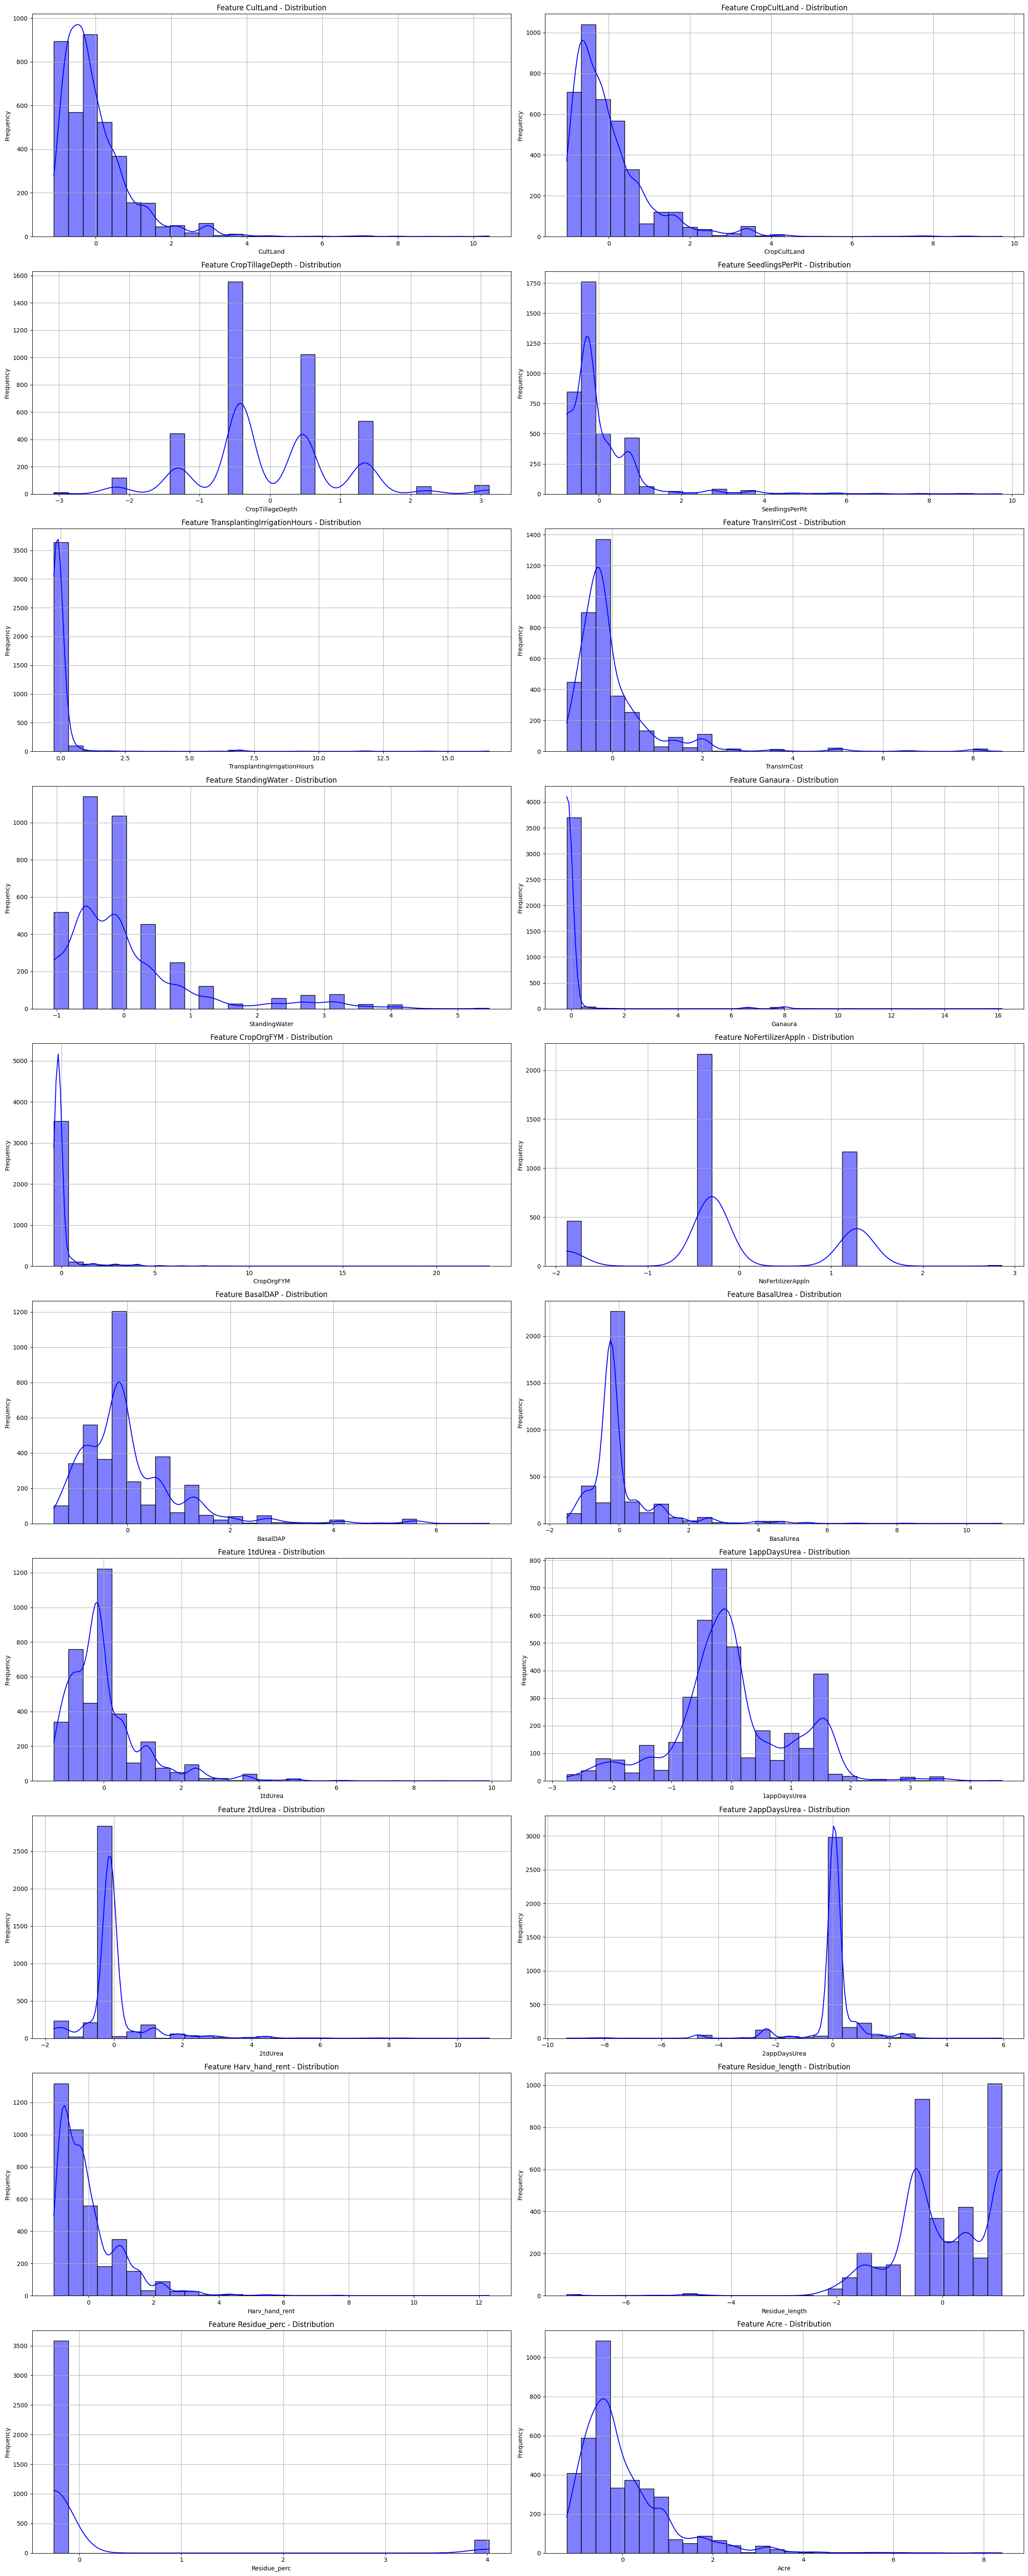

Plotting correlation matrix...


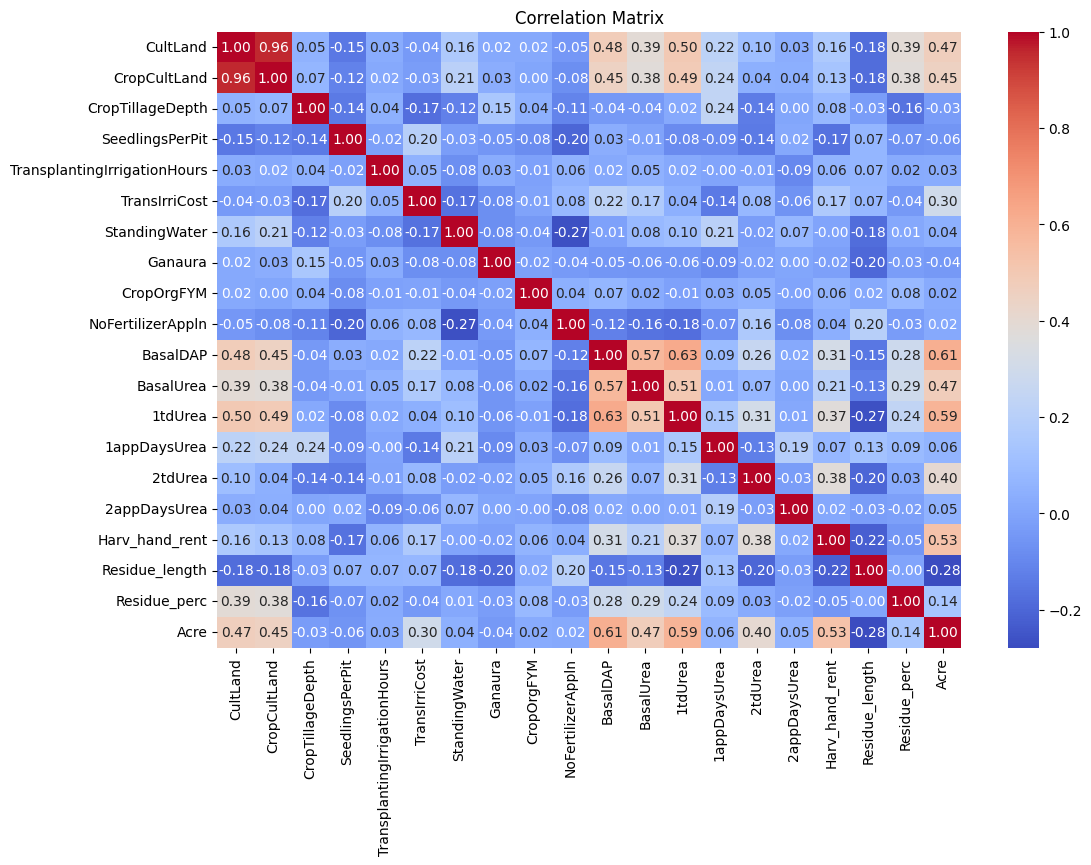

In [17]:
corr = analyze_distributions_and_correlation(all_data_scaled)

In [18]:
def remove_highly_correlated_features(data, correlation_threshold=0.7):
    corr_matrix = data.corr().abs()

    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    features_to_drop = [
        column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)
    ]
    
    reduced_data = data.drop(columns=features_to_drop)

    return reduced_data, features_to_drop


all_data_reduced, dropped_features = remove_highly_correlated_features(all_data_scaled)


In [19]:
from scipy.stats import boxcox

def transform_features(data):
    transformed_data = data.copy()
    transformations = {}
    
    for column in data.columns:
        skewness = data[column].skew()
        kurtosis = data[column].kurt()

        if skewness > 1 or kurtosis > 10:  # Strongly positive skew or high kurtosis
            transformed_data[column] = np.log1p(data[column] - data[column].min() + 1)
            transformations[column] = {"Transformation": "Log", "Skewness": skewness, "Kurtosis": kurtosis}
        elif skewness < -1:
            positive_data = data[column] - data[column].min() + 1  # Shift to positive
            transformed_data[column], _ = boxcox(positive_data)
            transformations[column] = {"Transformation": "Box-Cox", "Skewness": skewness, "Kurtosis": kurtosis}
        else:
            transformations[column] = {"Transformation": "None", "Skewness": skewness, "Kurtosis": kurtosis}
    
    return transformed_data, transformations


try:
    transformed_data, transformation_details = transform_features(all_data_reduced)
except Exception as e:
    print(f"An error occurred: {e}")

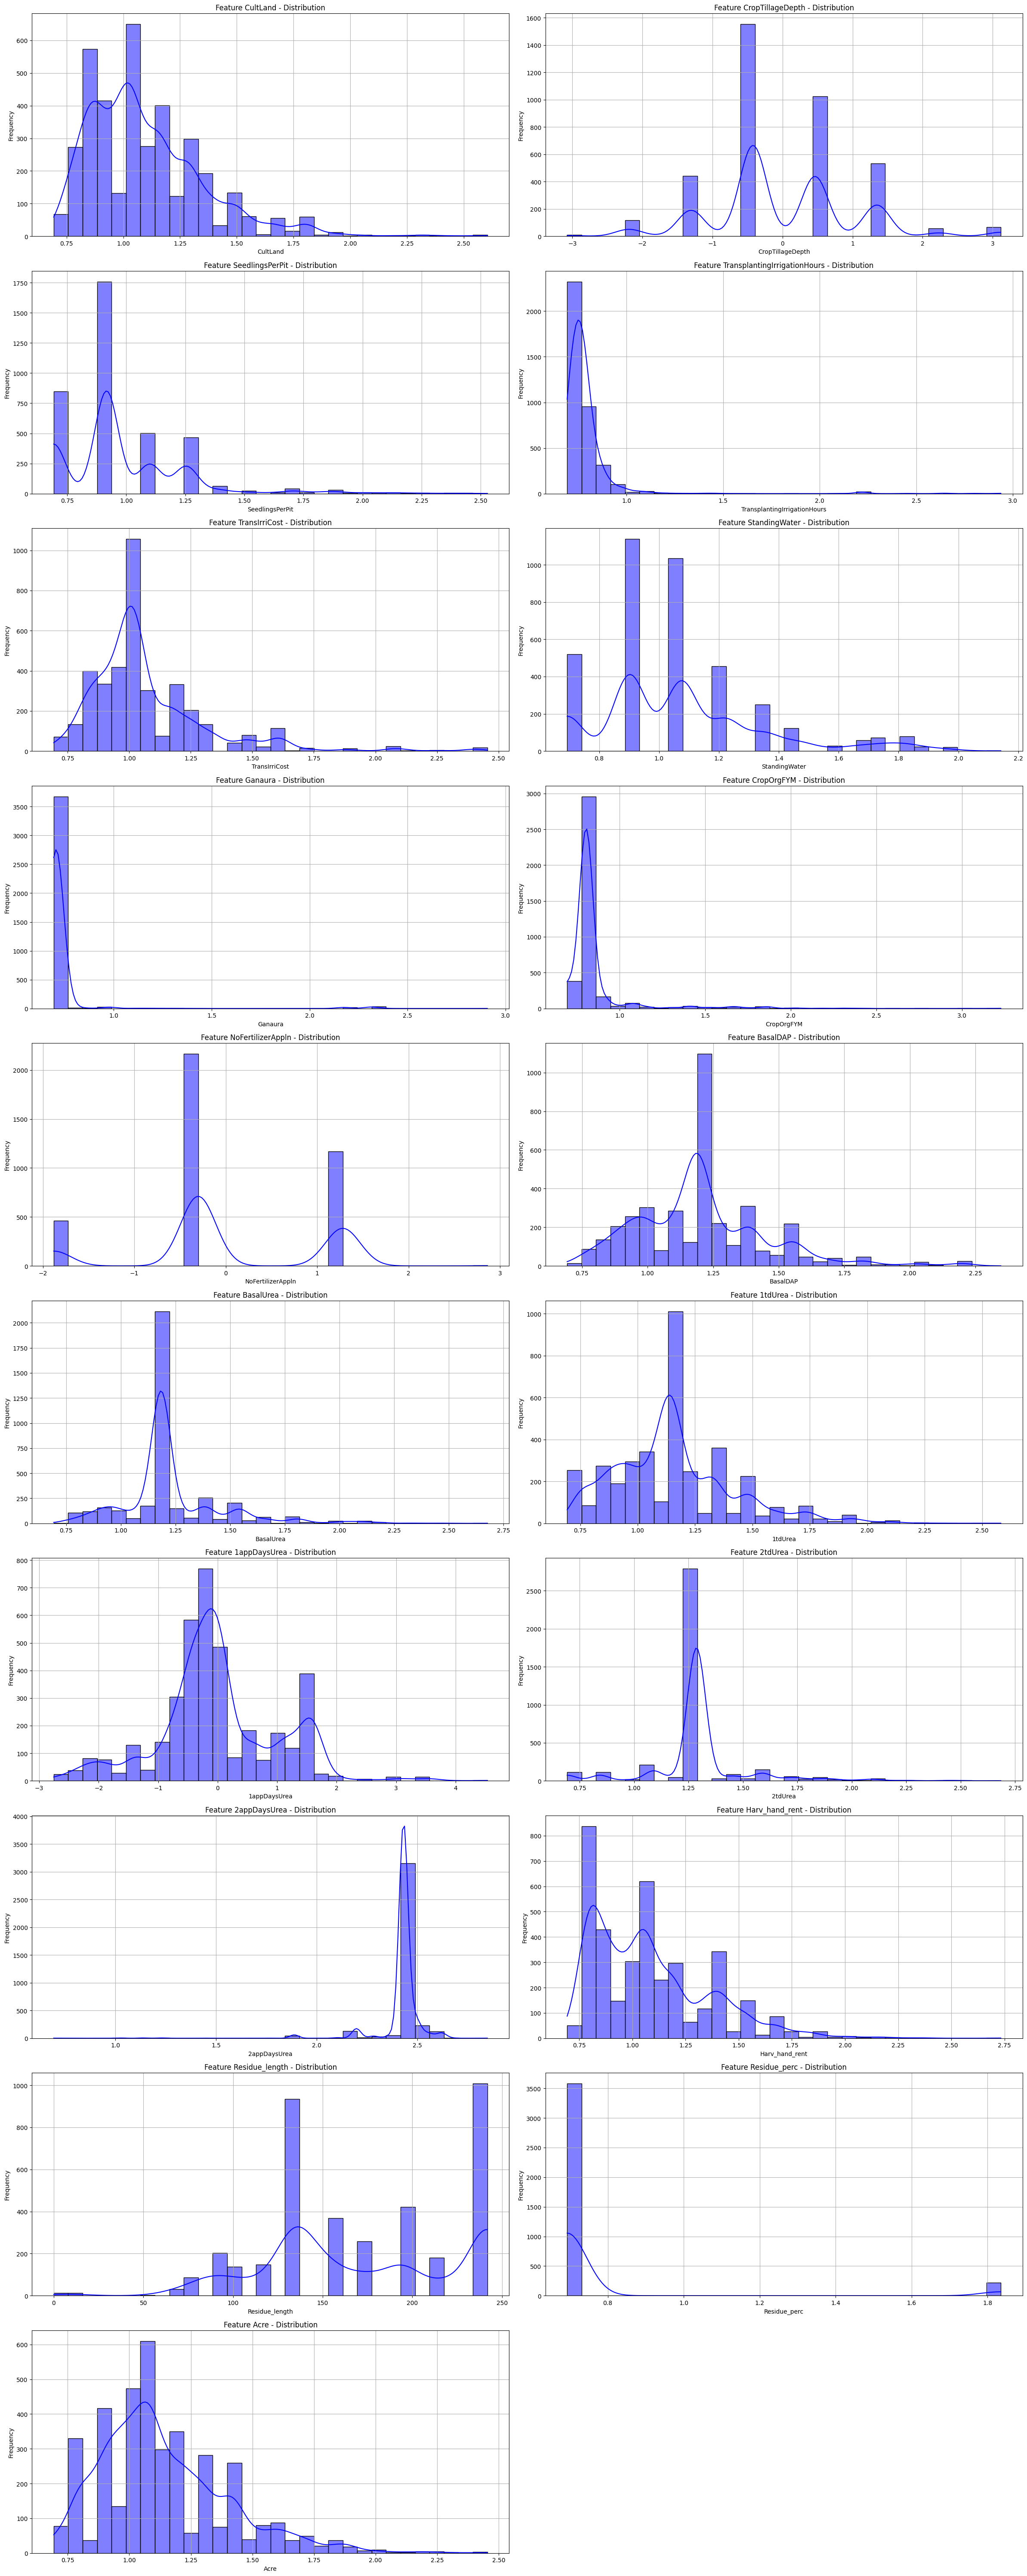

Plotting correlation matrix...


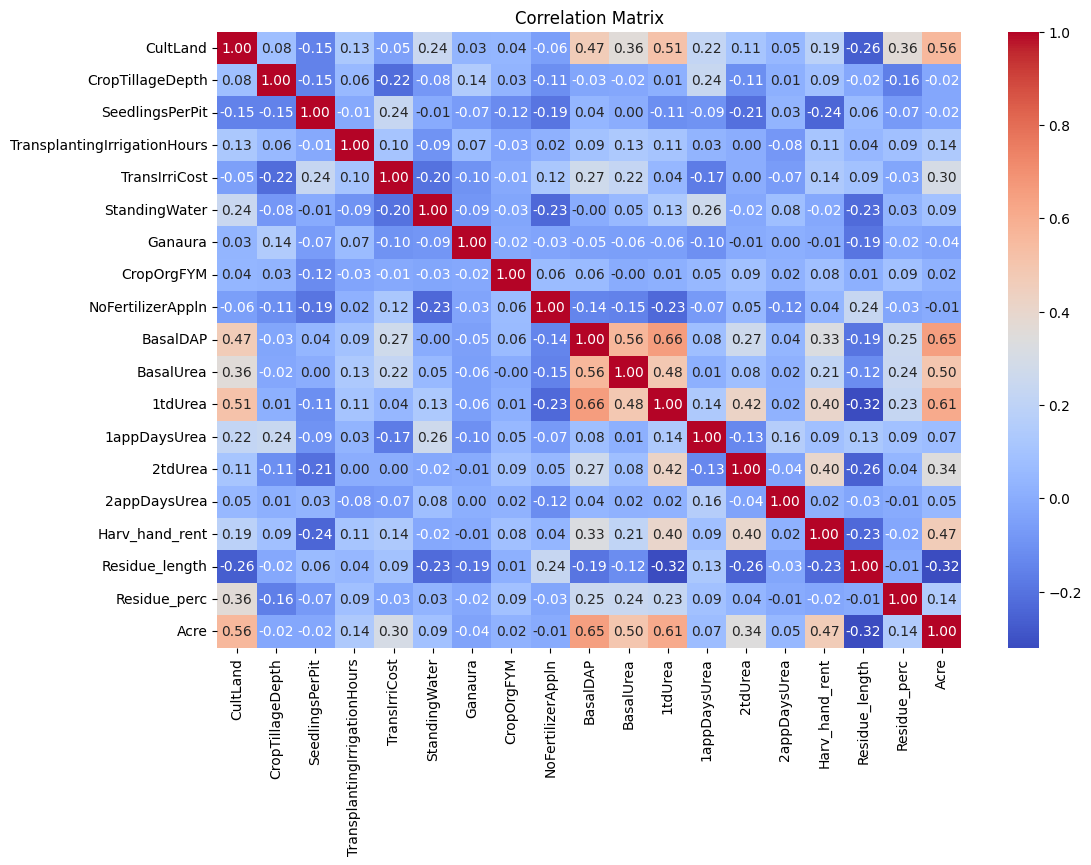

In [20]:
corr1 = analyze_distributions_and_correlation(transformed_data)

In [21]:
from sklearn.model_selection import train_test_split

train_data, test_data, y_train, y_test = train_test_split(transformed_data, y, test_size=0.1, random_state=42)
train_data, val_data, y_train, y_val = train_test_split(train_data, y_train, test_size=2./9, random_state=42) 

train = train_data
val = val_data
test = test_data

In [22]:
custom_model = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=1e-3,      
    l1_ratio=0.005,  
    lam=1e-2        
)

y_combined = pd.concat([y_train, y_val], axis=0)
y_combined_transformed, lambda_value = boxcox(y_combined + 1e-5)
y_train_transformed = y_combined_transformed[:len(y_train)]
y_val_transformed = y_combined_transformed[len(y_train):]


custom_model.fit(train, y_train_transformed)
y_pred = custom_model.predict(test)
if lambda_value == 0:
    y_pred_original = np.exp(y_pred) - 1
else:
    y_pred_original = (y_pred * lambda_value + 1)**(1 / lambda_value) - 1

report_df1 = regression_report(y_test, y_pred_original)
report_df1

c:\Users\edimv\Desktop\MOMO\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metric          Value
0    MAE     113.931639
1    MSE  160396.894122
2   RMSE     400.495810
3     R²       0.484861
4   MAPE      63.189252

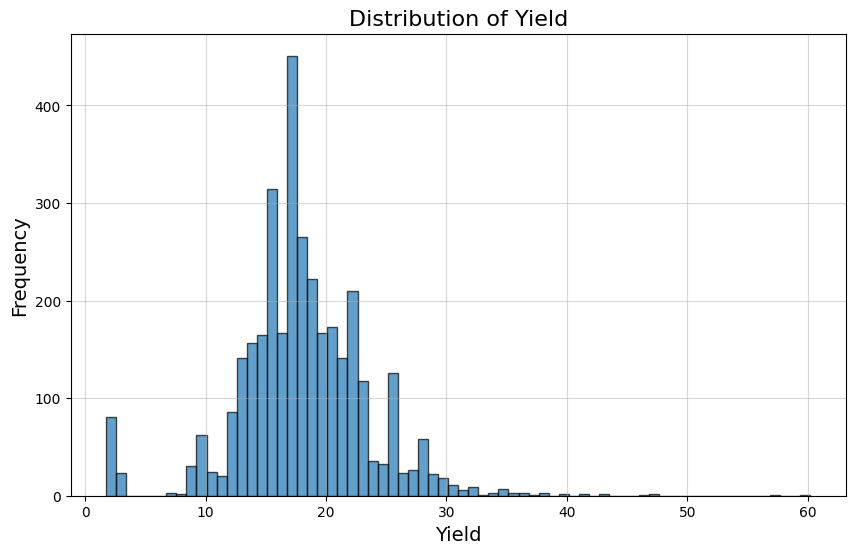

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(y_combined_transformed, bins=70, alpha=0.7, edgecolor='black')
plt.title('Distribution of Yield', fontsize=16)
plt.xlabel('Yield', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.5)
plt.show()

In [24]:
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    lam = trial.suggest_float('lam', 1e-3, 1e-1)

    model = LinearRegressionElasticNet(
        max_steps=10000,
        alpha=alpha,
        l1_ratio=l1_ratio,
        lam=lam
    )

    model.fit(train, y_train_transformed)
    y_pred = model.predict(val)

    rmse = np.sqrt(mean_squared_error(y_val_transformed, y_pred))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print(study.best_trial.params)


[I 2024-12-06 13:37:30,873] A new study created in memory with name: no-name-2cd3b281-e91e-4c0f-b862-d132db915c5e
[I 2024-12-06 13:37:33,662] Trial 0 finished with value: 3.071732981994443 and parameters: {'alpha': 0.05544176271650893, 'l1_ratio': 0.7309092518351346, 'lam': 0.09172493868612734}. Best is trial 0 with value: 3.071732981994443.
[I 2024-12-06 13:37:36,802] Trial 1 finished with value: 3.057453846241395 and parameters: {'alpha': 0.008137562511869086, 'l1_ratio': 0.6959004102771703, 'lam': 0.050460153530612534}. Best is trial 1 with value: 3.057453846241395.
[I 2024-12-06 13:37:54,396] Trial 2 finished with value: 3.0600291589181747 and parameters: {'alpha': 0.047265026739541256, 'l1_ratio': 0.47203070810649717, 'lam': 0.0608846188899713}. Best is trial 1 with value: 3.057453846241395.
[I 2024-12-06 13:38:08,782] Trial 3 finished with value: 3.061329750136956 and parameters: {'alpha': 0.0896084780067398, 'l1_ratio': 0.419648352601236, 'lam': 0.06690458112988111}. Best is tri

Best trial:
{'alpha': 0.009059948257844496, 'l1_ratio': 0.9299619899453078, 'lam': 0.03778698355368654}


In [25]:
best_params = study.best_trial.params

custom_model = LinearRegressionElasticNet(
    max_steps=10000,
    alpha=best_params['alpha'],
    l1_ratio=best_params['l1_ratio'],
    lam=best_params['lam']
)

custom_model.fit(train, y_train_transformed)
y_pred = custom_model.predict(test)

custom_model.fit(train, y_train_transformed)
y_pred = custom_model.predict(test)
if lambda_value == 0:
    y_pred_original = np.exp(y_pred) - 1
else:
    y_pred_original = (y_pred * lambda_value + 1)**(1 / lambda_value) - 1

report_df1 = regression_report(y_test, y_pred_original)
report_df1

c:\Users\edimv\Desktop\MOMO\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Metric          Value
0    MAE     109.595686
1    MSE  156733.681870
2   RMSE     395.896049
3     R²       0.496626
4   MAPE      71.151545

In [26]:
result = pd.merge(report_df, report_df1, on='Metric', how='outer')

result.to_csv("../metrics.csv", index=False)
result



Metric        Value_x        Value_y
0    MAE     182.104353     109.595686
1   MAPE     157.070054      71.151545
2    MSE  653910.601958  156733.681870
3   RMSE     808.647390     395.896049
4     R²       0.278784       0.496626

Получили весьма внушительные изменения в лучшую сторону по всем метрикам

In [27]:
train['Yield'] = y_train_transformed
train.to_csv("data/Train.csv", index=False)

val['Yield'] = y_val_transformed
val.to_csv("data/Val.csv", index=False)

test['Yield'] = y_test
test.to_csv("data/Test.csv", index=False)